In [111]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [112]:
path2data = 'data/'

In [113]:
df_train = pd.read_csv(path2data + 'train.csv', header = None)

In [114]:
X, y = df_train.iloc[:,1:-1].values, df_train.iloc[:,-1].values

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [116]:
def display_data(x, img_width = 20, img_height = 20):

    x = np.reshape(x, (img_width,img_height))
    x = x.astype('float32')
    plt.imshow(x.T)
    plt.set_cmap('gray')
    plt.axis('off')

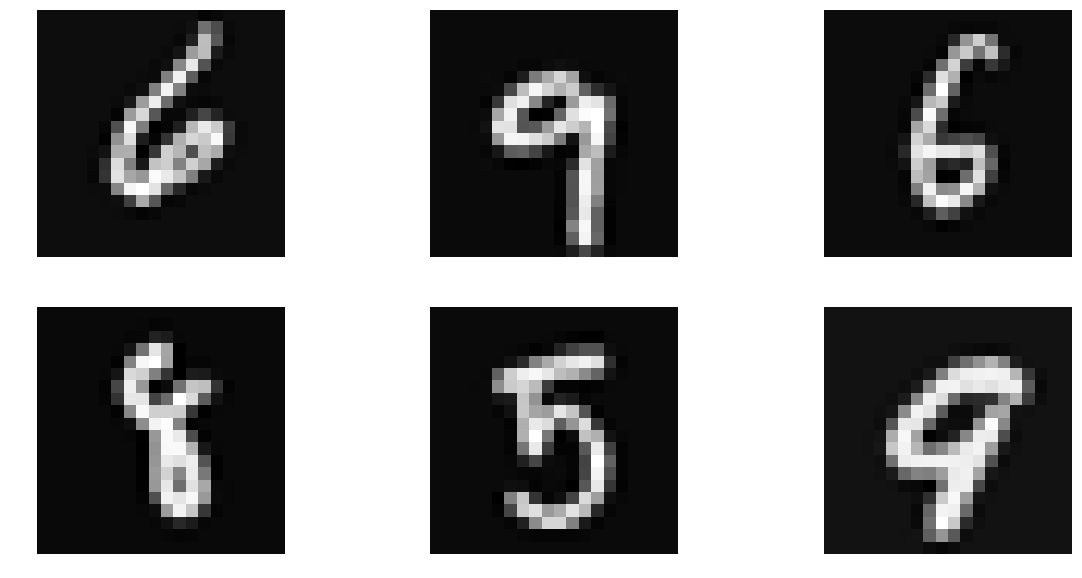

In [117]:
plt.figure(figsize=(20,10))
for i in range(0, 6):
    idx = randint(1, len(df_train))
    plt.subplot(2,3,i+1)
    display_data(X[idx,:])

In [118]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [119]:
# Turn up tolerance for faster convergence
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
predictions = logisticRegr.predict(X_test)

In [121]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.892107892108


In [122]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
        index +=1

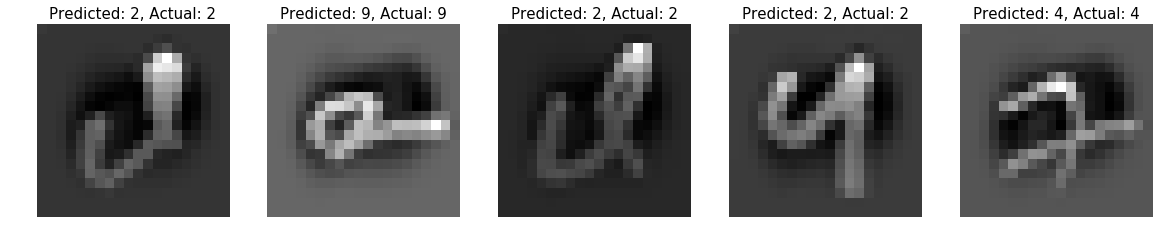

In [123]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (20,20)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], y_test[badIndex]), fontsize = 15)